

# Problem 1 - Linear Regression: Predicting California House Price (50 points)


In [78]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# models
## Scikit-Learn
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## Statsmodels
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, mutual_info_regression

# data
from sklearn.datasets import fetch_california_housing

# metrics
from sklearn.metrics import mean_squared_error, r2_score

# seaborn for visualization
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# statistics
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# # plotting
import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 10}
matplotlib.rc('font', **font)

## Helper function
# visualize the distribution of values a column, specified by 'column' ~ a column of a data frame, the name of the column is 'column_name' ~ a string
def visualize_distr(column_name, column):
    sns.distplot(column , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(column)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency')
    plt.title(column_name + ' distribution')


## 1. Data loading (5 points)
Requirement:
  - Read dataset, then show the first 5 rows of the dataset (2 points)
  - Use `visualize_distr` function to plot the distribution of the column `value` ~ the target of our linear regression(3 points). 

Run the following code cell to load the data and create a data frame.

In [79]:
# load the data
data = fetch_california_housing()

# create a Pandas Data Frame
df_features = pd.DataFrame(data['data'], columns=data['feature_names'])
df_targets  = pd.DataFrame(data['target'], columns=['value'])
# Concat the features and the target (df_targets is the output of our Linear Regression)
df = pd.concat([df_features, df_targets], axis=1)

Complete the following code cell so that the first 5 rows of the data will be printed (2 points).

In [80]:
# Print the first 5 rows of the data (2 points): 1 line of code
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Complete the following code cell to plot the distribution of the 'value' column (3 points).


 mu = 2.07 and sigma = 1.15



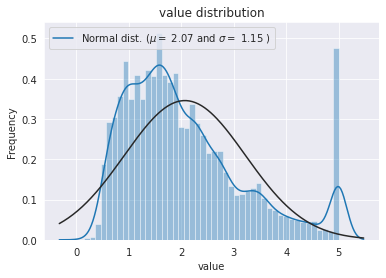

In [81]:
# Use the helper function defined above to plot the distribution of value (3 points): 1 line of code
visualize_distr('value',df['value'])

## 2. Data Pre-processing (15 points)

### 2.1 Fill in the misssing entries

Run the following code cell to confirm that there is no missing entries (fortunately!) ✌

In [82]:
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head(20)

,miss_rate


### 2.2 Remove highly correlated variables (5 points)

Run the following code cell to check the pairwise correlation among variables

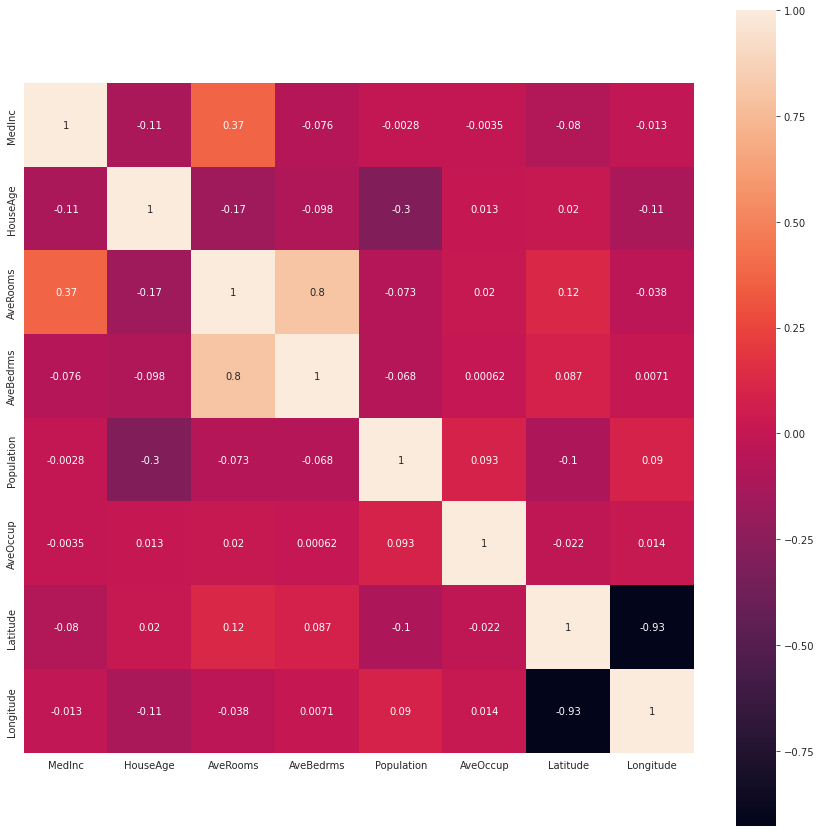

In [83]:
# Calculate the Correlation matrix of data frame without Dependent variable (Just on 25% of data)
corr_matrix = df.drop(columns=['value'])._get_numeric_data().sample(frac=0.25).corr()

# Plot the heatmap of Correlation
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix,vmax=1, annot=True, square=True);
plt.show()

Run the following code cell to find the column pairs having correlation > 0.8 (or < -0.8) to drop one variable in each pair. Fill in the appropriate value of `corr_threshold` (1 point)

In [84]:
# threshold above which is considered too high of a correlation. Complete this line of code by filling in the appropriate value (1 point)
corr_threshold = 0.8

# Create correlation matrix
corr_matrix = corr_matrix.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than the correlation threshold (which are the unnecessary columns and will be dropped)
to_drop_corr = [column for column in upper.columns if any(upper[column] >= corr_threshold)]

Complete the following code cell so that `train_df` will be our training data after dropping the unnecessary columns (3 points). In the next line, print the first 5 rows of `train_df` (1 point).

In [85]:
# Complete the following line: train_df is the data frame obtained by dropping the unnecessary columns (3 points).
train_df = df.drop(to_drop_corr, axis=1)
# Print the first 5 rows of train_df (1 point).
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,3.422


### 2.3 Feature Scaling (5 points)

Run the following code cell to extract indices the data column (excluding the `value` column). The indices of the data column will be in the variable `input_cols`.

In [86]:
# Exclude the value (target of prediction) column and select all numerical columns
input_cols = train_df.drop(columns=['value']).select_dtypes(include='number').columns
print(input_cols)
train_df[input_cols].head()

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude'],
      dtype='object')


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85


Complete the following code cell to Min-Max Scale the data (5 points).<br> Requirements:
- Define a MinMax Scaler (1 point).
- Fit the scaler to our data and return the scaled data to `scaled_df` (2 points). NOTE: only fit the scaler to the input columns (excluding the 'value' column).
- Scale the data by 1 line of code (1 point).
- Describe the scaled data with count, mean, std, min,... (1 point).

In [87]:
# Define a MinMax Scaler (1 point)
scaler = MinMaxScaler()

# Fit the scaler to our data and return the scaled data into 'scaled_df' (2 points). NOTE: only fit to the input columns (excluding the 'value' column).
scaled_df = scaler.fit_transform(train_df[input_cols])

# scale our data (1 point)
train_df[input_cols] = scaled_df

# describe the scaled data with count, mean, std, min,... (1 point)
train_df[input_cols].describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,0.232464,0.541951,0.032488,0.022629,0.039869,0.001914,0.328572
std,0.131020,0.246776,0.017539,0.014049,0.031740,0.008358,0.226988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142308,0.333333,0.025482,0.019943,0.021974,0.001398,0.147715
50%,0.209301,0.549020,0.031071,0.021209,0.032596,0.001711,0.182784
75%,0.292641,0.705882,0.036907,0.022713,0.048264,0.002084,0.549416
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.4 Train-Test Split (5 points)

Complete the following code cell. Define the `test_size_ratio` to be 0.2 (1 point). Split the data into `X_train, y_train, X_test, y_test` with the defined `test_size_ratio` (4 points).

In [88]:
# Define the test_size_ratio variable to be 0.2 (1 point)
test_size_ratio=0.2
# Split the data into X_train, X_test, y_train, and y_test with the defined test_size_ratio (4 points). NOTE: X_train and X_test only contain the input columns, NOT the 'value' column.
X_train, X_test, y_train, y_test = train_test_split(train_df[input_cols],train_df['value'],test_size= test_size_ratio,random_state=42)

Run the following code cell to print the shape of `X_train, y_train, X_test, y_test`.



In [89]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (16512, 7)
y_train.shape: (16512,)
X_test.shape: (4128, 7)
y_test.shape: (4128,)


## 3. Linear Regression with scikit-learn (10 points)

Complete the following code cell (5 points).
<br> Requirements:
- Create a lasso linear regression object (1 point).
- Train the model using the training set (1 point).
- Predict on the test set (1 point).
- Print the R-squared and Root Mean squared Error (2 points).

In [90]:
# Create linear regression object (1 point)
regr = Lasso()
# Train the model using the training set (1 point)
regr.fit(X_train, y_train)
# Predict on Test set (1 point)
y_pred =regr.predict(X_test)

# Evaluation on Test set
# Print R-squared (1 point)
print(f'R-squared = {r2_score(y_test,y_pred):.4f}')
# Print Mean Squared Error (1 point)
print(f'MSE       = {mean_squared_error(y_test,y_pred):.4f}')

R-squared = -0.0002
MSE       = 1.3107


Complete the following code cell so that `vif["VIF Factor"]` will be the VIF of EACH column of X_train (2 points).




VIF (variance inflation factor: hệ số phóng đại phương sai): $VIF= \frac{1}{1-R^2}$ \\
VIF lớn mô hình có thể xảy ra đa cộng tuyến

In [91]:
vif = pd.DataFrame()
# Complete the following line so that 'vif["VIF Factor"]' will be a column of VIF of each column of X_train.
vif["VIF Factor"] = [variance_inflation_factor(X_train.values,i) for i in range(len(X_train.columns))]

vif["features"] = X_train.columns
vif

,VIF Factor,features
0,7.214490,MedInc
1,3.844726,HouseAge
2,33.943072,AveRooms
3,23.493096,AveBedrms
4,2.179413,Population
5,1.051229,AveOccup
6,2.840289,Latitude


Complete the follwing code cell (3 points).
<br> Requirements:
- Select the columns having VIF smaller than 4 (1 point).
- Repeat the whole Linear Regression training, prediction, and evaluation process (2 points).

In [92]:
# selected_cols: the columns having VIF < 4 (1 point).
selected_cols = vif.loc[vif['VIF Factor']<4]['features']
# THE FOLLOWING CODE LINES WILL BE WORTH 2 POINTS.
# Split the data into X_train, X_test, y_train, and y_test with the defined test_size_ratio. NOTE: X_train and X_test only contain the selected columns.
X_train,X_test, y_train, y_test= train_test_split(train_df[selected_cols], train_df['value'],test_size= test_size_ratio, random_state= 42)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test,shape: ', X_test.shape)
print('y_test.shape: ',y_test.shape)
# Create linear regression object & train the model using the training set. Hint: 2 lines of code
model= LinearRegression()
model.fit(X_train, y_train)

# Predict on Test set
y_pred= model.predict(X_test)

# Evaluation on Test set: R-squared and Root Mean Squared Error.
# Print R-squared
print(f'R-squared = {r2_score(y_test, y_pred):.4f}')
# Print Root Mean Squared Error
print(f'MSE= {mean_squared_error(y_test,y_pred):.2f}')

X_train.shape:  (16512, 4)
y_train.shape:  (16512,)
X_test,shape:  (4128, 4)
y_test.shape:  (4128,)
R-squared = 0.0366
MSE= 1.26


What do you think about this performance?

Với mô hình hồi quy tuyến tính xây dựng bởi phương pháp Lasso có $R^2=-0.0002$ do đó mô hình này gần như không giải thích biến phụ thuộc.

Sau khi tính toán giá trị VIF để xác định có hay không đa cộng tuyến và loại bỏ đi các features có VIF >4 (có khả năng xảy ra đa cộng tuyến) thì với mô hình mới thích giải thích 3.66% biến giá nhà

## 4. Select features with `statsmodels` and `seletKbest`(10 points)

Complete the following code cell (1 point).
<br> Requirements:
- Train-Test Split: 1 line of code
- Train & Interpret the model with `statsmodel`: 3 lines of code.

In [94]:
# Train-Test Split according to the test_size_ratio defined above. Hint: 1 line of code.
X_train, X_test, y_train, y_test= train_test_split(train_df[input_cols], train_df['value'], test_size= test_size_ratio, random_state= 42)

# Train & Interpret the model with statsmodel. Hint: 3 lines of code.
est= sm.OLS(y_train, X_train)
est2= est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                          1.965e+04
Date:                Wed, 04 May 2022   Prob (F-statistic):                        0.00
Time:                        15:01:31   Log-Likelihood:                         -19256.
No. Observations:               16512   AIC:                                  3.853e+04
Df Residuals:                   16505   BIC:                                  3.858e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<br> Requirements:
- Type your answer to the question: looking at the above interpretation, should we remove any variable/features? Why? (1 point).


Từ kết quả trên nhận thấy các giá trị p- value đều bằng xấp xỉ 0 nên không nên loại bỏ bất kì biến nào cả vì sự khác biệt trong mô hình khi loại bỏ một biến i nào đó với mô hình không loại bỏ biến i mang ý nghĩa thống kê.

Complete the following code cell (8 points).
<br> Requirements:
- Use `selectKBest` to select the best 5 features (4 points).
- Select the features with `p-value` < 0.05 (4 points).

In [100]:
# Select KBest: 4 points.
# Split Train-Test
X_train, X_test, y_train, y_test= train_test_split(train_df[input_cols], train_df['value'], test_size= test_size_ratio, random_state= 42)
# Number of selected features: 4
num_selected= 5 
selector= SelectKBest(f_regression, k= num_selected)
selector.fit(X_train, y_train)
X_train_selected= selector.transform(X_train)
# Create linear regression object & train on the training set
regr= LinearRegression()
# Train model and Predict on Test set
regr.fit(X_train_selected, y_train)
X_test_selected= selector.transform(X_test)
y_pred= regr.predict(X_test_selected)
# Evaluation on Test set
# R-squared
print(f'R- squared= {r2_score(y_test, y_pred):.4f}')
# Mean Squared Error
print(f'MSE ={mean_squared_error(y_test, y_pred):.4f}')

R- squared= 0.5129
MSE =0.6383


In [102]:
# p-values: 4 points.
# Compute F-statistics and p-values
f,p= f_regression(X_train, y_train)

# Create a DataFrame for F-statistics and p-values
df_significance= pd.DataFrame({'Feature':input_cols,'F-statistic': f, 'p-value':p})
print(df_significance)
# Select the features associated with p-values < significance level
significance_level= 0.05
selected_features= df_significance[df_significance['p-value']<significance_level]['Feature']
print(selected_features)

      Feature   F-statistic       p-value
0      MedInc  15057.439100  0.000000e+00
1    HouseAge    179.495552  1.019198e-40
2    AveRooms    425.373449  2.473178e-93
3   AveBedrms     43.650715  4.045321e-11
4  Population     11.196169  8.214916e-04
5    AveOccup      8.016509  4.640889e-03
6    Latitude    344.579030  3.821798e-76
0        MedInc
1      HouseAge
2      AveRooms
3     AveBedrms
4    Population
5      AveOccup
6      Latitude
Name: Feature, dtype: object


In [103]:
# Split Train-Test, Create object, Train, Test, and Evaluate.
X_train, X_test, y_train, y_test= train_test_split(train_df[selected_features], train_df['value'], test_size= test_size_ratio, random_state= 42)
regr= LinearRegression()
# Train the model using the training set
regr.fit(X_train, y_train)
# Predict on Test set
y_pred= regr.predict(X_test)
# Evaluation on Test set
#R- quared
print(f'R- squared= {r2_score(y_test, y_pred):.4f}')
# Mean Squared Error
print(f'MSE = {mean_squared_error(y_test, y_pred):.4f}')

R- squared= 0.5139
MSE = 0.6370


## 5. Lasso & Ridge Linear Regression (10 points)

### 5.1 Lasso Linear Regression (5 points)

Complete the following code cell (5 points).
<br> Requirements:
- Train-Test split: according to the `test_size_ratio` defined above (1 point).
- Create a lasso linear regression object (1 point).
- Train the model using the training set (1 point).
- Predict on the test set (1 point).
- Print the R-squared and Root Mean squared Error (1 point).


In [104]:
# Train test split
X_train, X_test, y_train, y_test= train_test_split(train_df[input_cols], train_df['value'], test_size= test_size_ratio, random_state= 42)
# Create a Lasso linear regression object
regr= Lasso()
# Train the model using the training set
regr.fit(X_train, y_train)
# Predict on the test set
y_pred= regr.predict(X_test)
# Evaluation'
#R- squared
print(f'R- squared= {r2_score(y_test, y_pred):.4f}')
# Mean Squared Error
print(f'MSE= {mean_squared_error(y_test, y_pred):.4f}')

R- squared= -0.0002
MSE= 1.3107


### 5.2 Ridge Linear Regression (5 points)


Complete the following code cell (5 points).
<br> Requirements:
- Train-Test split: according to the `test_size_ratio` defined above (1 point).
- Create a ridge linear regression object (1 point).
- Train the model using the training set (1 point).
- Predict on the test set (1 point).
- Print the R-squared and Root Mean squared Error (1 point).


In [105]:
# Train test split
X_train, X_test, y_train, y_test= train_test_split(train_df[input_cols], train_df['value'], test_size= test_size_ratio, random_state=42)
# Create a ridge linear regression object
regr= Ridge()
# Train the model using the trainning set
regr.fit(X_train, y_train)
# Predict on the test set
y_pred= regr.predict(X_test)
#Evaluation
#R-squared
print(f'R- squared= {r2_score(y_test, y_pred):.4f}')
# Mean Squared Error
print(f'MSE= {mean_squared_error(y_test, y_pred):.4f}')

R- squared= 0.5126
MSE= 0.6387


## 6. Random Forest Regression (Optional).

---



Complete the following code cell to do Regression using Random Forest. Learners are encouraged to complete this part.

In [106]:
# Train-Test Split
X_train, X_test, y_train, y_test= train_test_split(train_df[input_cols], train_df['value'], test_size= test_size_ratio, random_state=42)

# Create Random Forest regressor object & Train the model on the Training set. Hint: 2 lines of code
regr= RandomForestRegressor()
regr.fit(X_train, y_train)
# Predict on the Test set
y_pred= regr.predict(X_test)

# Evaluation on Test set: R-squared & Root Mean squared Error. 
#R-squared
print(f'R- squared= {r2_score(y_test, y_pred):.4f}')
#Mean Squared Error
print(f'MSE= {mean_squared_error(y_test, y_pred):.4f}')


R- squared= 0.7310
MSE= 0.3526


## 7. Decision Tree Regression (Optional).


Complete the following code cell to do Regression using Decision Tree. Learners are encouraged to complete this part.

In [107]:
# Train-Test Split
X_train, X_test, y_train, y_test= train_test_split(train_df[input_cols], train_df['value'], test_size= test_size_ratio, random_state= 42)

# Create Decision Tree regressor object & Train the model on the Training set. Hint: 2 lines of code
regr= DecisionTreeRegressor()
regr.fit(X_train,y_train)
# Predict on the Test set
y_pred= regr.predict(X_test)
# Evaluation on Test set: R-squared & Root Mean squared Error. 
#R-squared
print(f'R-squared = {r2_score(y_test, y_pred):.4f}')
#Mean Squared Error
print(f'MSE= {mean_squared_error(y_test, y_pred):.4f}')

R-squared = 0.4703
MSE= 0.6941


# Problem 2 - Logistic Regression: Predicting breast cancer (50 points)




In [109]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix
from sklearn.datasets import load_breast_cancer


# plotting
import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 18}
matplotlib.rc('font', **font)


# Helper function
def get_label_counts(labels):
  label_counts = pd.Series(labels).value_counts().reset_index(name='counts')
  label_counts['percent (%)'] = (label_counts['counts'] / labels.shape[0] * 100).round(2)
  label_counts = label_counts.rename(columns={'index': 'class'}).set_index('class')
  return label_counts

## 1. Data loading (10 points)
Requirement:
  - Read dataset, then show info and head of the dataset (5 points)
  - Use `get_label_counts` function to print the label distribution of dataset (5 points). Do you have any comment about the label distribution ?

In [110]:
data = load_breast_cancer()
# Optional: You can uncomment the line below to see how the variable `data` looks like
data

{'DESCR': '.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry\n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        worst/largest values) of these features were computed for each image,\n        resulting in 30 features.

In [111]:
df_features = pd.DataFrame(data['data'], columns=data['feature_names'])
df_targets  = pd.DataFrame(data['target'], columns=['class'])
df = pd.concat([df_features, df_targets], axis=1)

# === Write your code here to print dataset info and head ===
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [113]:
X = df.drop(columns=['class'])
y = df['class']

# === Write your code here to show the label distribution === 
get_label_counts(y)


,counts,percent (%)
class,,
1,357,62.74
0,212,37.26


## 2. Data preprocessing (10 points)

### 2.1. Fill nulls: fortunately, this dataset has no null values

### 2.2. Train - test split (10 points)
- Requirement: stratified by *y*
- The test_size is up to you

In [114]:
# === Write your code here to split data 
test_size=0.2
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= test_size, random_state=42, stratify=y)
# ==========================================

# Check the label distribution of training set, the percent should be approx. 62.64% : 37.36%
print("Training set label distributions")
get_label_counts(y_train)

Training set label distributions


,counts,percent (%)
class,,
1,285,62.64
0,170,37.36


## 3. Train (10 points)

Requirement:
- Feature scaling before training, use Standard Scaler

### 3.1. Feature scaling (5 points)

In [115]:
# === Write your code here to scale features ===
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled= pd.DataFrame(scaler.transform(X_train), columns= X_train.columns)
X_train_scaled.head()
# ==========================================

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-1.072001,-0.658425,-1.088080,-0.939274,-0.135940,-1.008718,-0.968359,-1.102032,0.281062,-0.113231,...,-1.034094,-0.623497,-1.070773,-0.876534,-0.169982,-1.038836,-1.078995,-1.350527,-0.352658,-0.541380
1,1.748743,0.066502,1.751157,1.745559,1.274468,0.842288,1.519852,1.994664,-0.293045,-0.320180,...,1.228342,-0.092833,1.187467,1.104386,1.517001,0.249655,1.178594,1.549916,0.191078,-0.173739
2,-0.974734,-0.931124,-0.997709,-0.867589,-0.613515,-1.138154,-1.092292,-1.243358,0.434395,-0.429247,...,-0.973231,-1.036772,-1.008044,-0.834168,-1.097823,-1.167260,-1.282241,-1.707442,-0.307734,-1.213033
3,-0.145103,-1.215186,-0.123013,-0.253192,0.664482,0.286762,-0.129729,-0.098605,0.555635,0.029395,...,-0.251266,-1.369643,-0.166633,-0.330292,0.234006,0.096874,-0.087521,-0.344838,0.242198,-0.118266
4,-0.771617,-0.081211,-0.803700,-0.732927,-0.672282,-1.006099,-0.798502,-0.684484,0.737495,-0.457213,...,-0.801135,0.079230,-0.824381,-0.741830,-0.911367,-0.984612,-0.933190,-0.777604,0.555118,-0.761639


In [116]:
# Checking the max values before and after scaling:
print('Max values before scaling:')
print(X_train.max(axis=0)[:5])
print('-----------------------------')
print('Max values after scaling:')
print(X_train_scaled.max(axis=0)[:5])

Max values before scaling:
mean radius          28.1100
mean texture         39.2800
mean perimeter      188.5000
mean area          2499.0000
mean smoothness       0.1447
dtype: float64
-----------------------------
Max values after scaling:
mean radius        4.017353
mean texture       4.552410
mean perimeter     4.018733
mean area          5.370416
mean smoothness    3.610271
dtype: float64


### 3.2. Train model (5 points)
Requirement:
- Use LogisticRegression to fit training data

In [117]:
logreg= LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

## 4. Predict & Test (10 points)
Requirement:
- Classification report: both train & test datasets (5 points)
- AUC score: both train & test datasets (5 points)
- (Optional) Give your feedback about the scores. For example: Are you overfitting? Is the model good enough ? What if you didn't apply feature scaling ?


In [118]:
X_test_scaled= pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)
y_pred= logreg.predict(X_test_scaled)
print('y_pred', y_pred)

y_pred [0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1
 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0
 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1
 0 1 1]


In [119]:
# Checking the performance
report= classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [121]:
# Check the AUC score
y_score= logreg.predict_proba(X_test_scaled)
print('y_scored: ', y_score)

y_scored:  [[9.99999940e-01 6.00504239e-08]
 [1.14722307e-05 9.99988528e-01]
 [9.93588857e-01 6.41114300e-03]
 [4.64263604e-01 5.35736396e-01]
 [9.99999999e-01 6.68694350e-10]
 [7.95928019e-03 9.92040720e-01]
 [1.76307009e-05 9.99982369e-01]
 [9.99999417e-01 5.83013733e-07]
 [9.99945096e-01 5.49035922e-05]
 [1.00000000e+00 8.12728022e-11]
 [1.08402350e-02 9.89159765e-01]
 [9.98659874e-01 1.34012621e-03]
 [1.30530690e-03 9.98694693e-01]
 [9.99973481e-01 2.65190367e-05]
 [9.99721337e-01 2.78663474e-04]
 [9.75558285e-02 9.02444171e-01]
 [6.35674887e-01 3.64325113e-01]
 [1.66695987e-01 8.33304013e-01]
 [3.39266345e-05 9.99966073e-01]
 [1.70851772e-02 9.82914823e-01]
 [9.98324663e-01 1.67533736e-03]
 [9.47717568e-01 5.22824317e-02]
 [1.95922643e-04 9.99804077e-01]
 [9.09874050e-04 9.99090126e-01]
 [1.01692443e-02 9.89830756e-01]
 [1.31881996e-01 8.68118004e-01]
 [9.99999995e-01 4.96846639e-09]
 [9.76814204e-03 9.90231858e-01]
 [8.51426498e-04 9.99148574e-01]
 [1.08665432e-03 9.98913346e-01]

In [122]:
y_score= y_score[:,1]
auc_score= roc_auc_score(y_test, y_pred)
print('AUC: ', auc_score)

AUC:  0.9811507936507937


## 5. Analysis (10 points)
Requirement:
- Confusion matrix (5 points)
- (Optional) With this kind of dataset (breast cancer), do you think the precision or the recall is more important ? Why ?
- Sorted feature importances (or weights) (5 points).

Now you know which features having the most influence to the dangerous extent of a breast cancer :)


### Confusion matrix

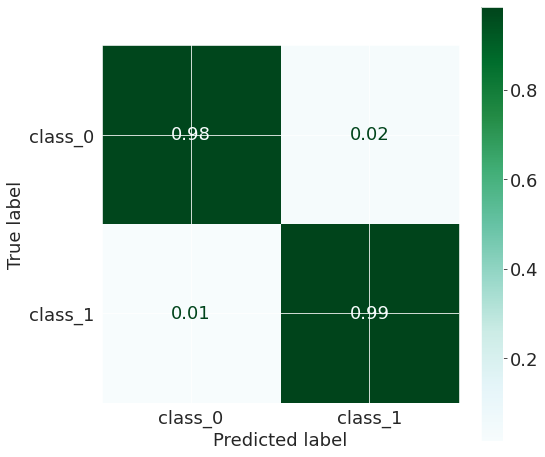

In [124]:
fig, ax= plt.subplots(figsize=(8,8))
plot_confusion_matrix(estimator=logreg, X= X_test_scaled, y_true= y_test, ax=ax, cmap='BuGn',
                      display_labels=['class_0', 'class_1'],
                      values_format='.2f',
                      normalize ='true');

### Weight of features

In [125]:
print('intercept (w_0)= ', logreg.intercept_)
print('weight (w_1 to w_n)', logreg.coef_)

intercept (w_0)=  [0.30051159]
weight (w_1 to w_n) [[-0.50506975 -0.55873422 -0.47140795 -0.53873734 -0.20771839  0.65362708
  -0.60657859 -0.70001318 -0.17298559  0.19360875 -1.08427851  0.25114768
  -0.5372148  -0.93489448 -0.15813328  0.64272374  0.17128749 -0.44708449
   0.35878449  0.43561586 -0.9451252  -1.24833214 -0.76142429 -0.95370642
  -0.75297843  0.04381431 -0.82886055 -0.94845784 -0.9352194  -0.17203651]]


In [126]:
weight_df= pd.DataFrame(data= logreg.coef_.T, columns=['weight'], index= X.columns).reset_index().rename(columns={'index':'feature_names'})
weight_df.head()

,feature_names,weight
0,mean radius,-0.505070
1,mean texture,-0.558734
2,mean perimeter,-0.471408
3,mean area,-0.538737
4,mean smoothness,-0.207718


In [127]:
weight_df['abs_weight']= weight_df['weight'].abs()
weight_df= weight_df.sort_values(by='abs_weight', ascending= False)
weight_df

,feature_names,weight,abs_weight
21,worst texture,-1.248332,1.248332
10,radius error,-1.084279,1.084279
23,worst area,-0.953706,0.953706
27,worst concave points,-0.948458,0.948458
20,worst radius,-0.945125,0.945125
28,worst symmetry,-0.935219,0.935219
13,area error,-0.934894,0.934894
26,worst concavity,-0.828861,0.828861
22,worst perimeter,-0.761424,0.761424
24,worst smoothness,-0.752978,0.752978
